# First Analysis of Results from Exact Diagonalization

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import hydra
import h5py
import os

from hydra import compose, initialize
from omegaconf import OmegaConf

In [11]:
from typing import Callable

# every argument after * must be passed as a keyword argument
def plot_xy(
    x: np.ndarray,
    y: np.ndarray,
    *,
    xlabel: str,
    ylabel: str,
    title: str,
    loglog: bool = False,
    guide_line: Callable | None = None,
    guide_label: str | None = None
):
    """
    Generic plotting helper.

    Parameters
    ----------
    x, y : array-like
        Data to plot.
    xlabel, ylabel, title : str
        Axis labels and title.
    loglog : bool
        If True, make a log-log plot.
    guide_line : callable
        A function f(x) that returns a reference line to plot.
    guide_label : str
        Label for the reference line.
    """
    plt.figure()

    if loglog:
        plt.loglog(x, y, label=ylabel)
        if guide_line is not None:
            plt.loglog(x, guide_line(x), 'k--', label=guide_label)
    else:
        plt.plot(x, y, label=ylabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def plot_photon_number_vs_omega(omega_list, photon_numbers):
    plot_xy(
        omega_list, photon_numbers,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Photon Frequency"
    )

def plot_photon_number_vs_omega_log_log(omega_list, photon_numbers):
    plot_xy(
        omega_list, photon_numbers,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Photon Frequency (Log-Log Scale)",
        loglog=True
    )

def plot_entanglement_entropy_vs_omega_log_log(omega_list, entropies):
    plot_xy(
        omega_list, entropies,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel='Entanglement Entropy',
        title="Entanglement Entropy vs Photon Frequency (Log-Log Scale)",
        loglog=True,
        guide_line=lambda x: 1/x**2,
        guide_label=r'$1/\Omega^2$'
    )

def plot_photon_number_vs_U(U_list, photon_numbers):
    plot_xy(
        U_list, photon_numbers,
        xlabel='Interaction Strength U',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Interaction Strength U"
    )

def plot_entanglement_entropy_vs_U(U_list, entropies):
    plot_xy(
        U_list, entropies,
        xlabel='Interaction Strength U',
        ylabel='Entanglement Entropy',
        title="Entanglement Entropy vs Interaction Strength U"
    )


def plot_ground_state_amplitudes_vs_U(U_list: np.ndarray, ground_states: np.ndarray):
    # plot the absolute square of the ground state coefficients per sites for various U
    # as a colormap. Start at the top of the plot with the lowest U and go down to highest U
    plt.figure()
    plt.imshow(np.abs(ground_states)**2, aspect='auto', extent=[0, len(ground_states[0]), U_list[-1], U_list[0]]) # type: ignore
    plt.colorbar(label='|Coefficient|^2')
    plt.xlabel('Basis State Index')
    plt.ylabel('Interaction Strength U')
    plt.title('Ground State Coefficients vs Interaction Strength U')
    plt.show()


# def plot_ground_state_vs_U(basis: Basis, U_list: np.ndarray, ground_states: np.ndarray):
#     # assume that we have purely fermionic basis for now
#     # take the state with the highest amplitude in each ground state, obtain its binaray representation
#     # and plot its occupation per site vs U
#     L = basis.L
#     dominant_states = []
#     for gs in ground_states:
#         max_idx = np.argmax(np.abs(gs))
#         dominant_state = basis.states[max_idx]
#         dominant_states.append(dominant_state)

#     plt.figure()
#     for site in range(L):
#         occupations = [(state[0] >> site) & 1 for state in dominant_states]
#         plt.plot(U_list, occupations, label=f'Site {site}')
#     plt.xlabel('Interaction Strength U')
#     plt.ylabel('Occupation')
#     plt.title('Dominant Ground State Occupation vs Interaction Strength U')
#     plt.legend()
#     plt.grid()
#     plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional


def plot_multi_xy(
    curves: list[tuple[np.ndarray, np.ndarray, str]],
    *,
    xlabel: str,
    ylabel: str,
    title: str,
    loglog: bool = False,
    guide_line: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    guide_label: Optional[str] = None,
):
    """
    Plot multiple (x, y) curves in a single figure.

    curves: list of (x, y, label) tuples
    """
    plt.figure()

    # Plot optional guide function (must use the x-values of the first curve)
    if loglog and guide_line is not None:
        x0, _, _ = curves[0]
        plt.loglog(x0, guide_line(x0), 'k--', label=guide_label)

    # Plot each curve
    for x, y, label in curves:
        if loglog:
            plt.loglog(x, y, label=label)
        else:
            plt.plot(x, y, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def plot_observable_vs_U_multi(results_dict, observable):
    curves = []
    for N_ph, results in results_dict.items():
        U_list, photon_nums = results
        curves.append((U_list, photon_nums, f"N_ph={N_ph}"))

    plot_multi_xy(
        curves,
        xlabel="U",
        ylabel=observable,
        title=f"{observable} vs U for Different Photon Cutoffs",
    )

def loglog_plot_observable_vs_omega_multi(results_dict, observable):
    curves = []
    for N_ph, results in results_dict.items():
        omega_list, entropies = results
        curves.append((omega_list, entropies, f"N_ph={N_ph}"))

    if observable == "entanglement_entropy":
        guide_line=lambda x: 1/x**2
        guide_label=r'$\propto 1/\Omega^2$'
    else:
        guide_line=None
        guide_label=None

    plot_multi_xy(
        curves,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=observable,
        title=f'{observable} vs Omega (Different Photon Cutoffs)',
        loglog=True,
        guide_line=guide_line,
        guide_label=guide_label
    )





In [13]:
initialize(version_base=None, config_path="../../conf")
cfg = compose(config_name="config")
print(OmegaConf.to_yaml(cfg))

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [14]:

# root_data_dir = os.path.expanduser(cfg.root_data_dir)
root_data_dir = cfg.root_data_dir
print(f"Root data directory: {root_data_dir}")


Root data directory: /data/xxz_cavity/exact_diagonalization/


In [15]:
def print_hdf5_tree(filename):
    def print_attrs(name, obj):
        print(name)
        # for key, val in obj.attrs.items():
        #     print(f"  [ATTR] {key}: {val}")
        if isinstance(obj, h5py.Dataset):
            print(f"  [DATASET] shape={obj.shape}, dtype={obj.dtype}")
    with h5py.File(filename, "r") as f:
        f.visititems(print_attrs)

filename = "ed_results_omega_sweep.h5"
data_path = os.path.join(root_data_dir, filename)
print_hdf5_tree(data_path)


L=4_N_f=2_N_ph=10_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5
L=4_N_f=2_N_ph=10_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5/entanglement_entropy
  [DATASET] shape=(2, 13), dtype=float64
L=4_N_f=2_N_ph=10_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5/photon_number
  [DATASET] shape=(2, 13), dtype=float64
L=4_N_f=2_N_ph=12_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5
L=4_N_f=2_N_ph=12_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5/entanglement_entropy
  [DATASET] shape=(2, 13), dtype=float64
L=4_N_f=2_N_ph=12_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5/photon_number
  [DATASET] shape=(2, 13), dtype=float64
L=4_N_f=2_N_ph=14_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5
L=4_N_f=2_N_ph=14_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5/entanglement_entropy
  [DATASET] shape=(2, 13), dtype=float64
L=4_N_f=2_N_ph=14_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5/photon_number
  [DATASET] shape=(2, 13), dtype=float64
L=4_N_f=2_N_ph=16_boundary_conditions=periodic_t=1.0_U=3.0_g=0.5

In [22]:
photon_cutoffs = [1, 2, 4, 6, 8] #, 10, 12, 14, 16
L = 8
N_f = L // 2
observable = "entanglement_entropy"
# observable = "photon_number"
results_all_photon_cutoffs = {}

for N_ph in photon_cutoffs:
    # group_name = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions=periodic_t=1.0_g=0.5_omega=10.0"
    group_name = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions=periodic_t=1.0_g=0.5_U=3.0"

    # get data from hdf5 file
    print(f"Loading data for N_ph={N_ph} from group: {group_name}")
    with h5py.File(data_path, "r") as f:
        obj = f[f"{group_name}/{observable}"]
        assert isinstance(obj, h5py.Dataset), f"Expected h5py.Dataset, got {type(obj)}"
        results = obj[()]
        print(f"Results shape: {results.shape}")
        print(f"first 5 results: {results[0][0:5]}\n{results[1][0:5]}")
        results_all_photon_cutoffs[N_ph] = results
    

Loading data for N_ph=1 from group: L=8_N_f=4_N_ph=1_boundary_conditions=periodic_t=1.0_g=0.5_U=3.0
Results shape: (2, 13)
first 5 results: [ 1.    9.25 17.5  25.75 34.  ]
[0.17990679 0.00922935 0.00301992 0.00148322 0.00087913]
Loading data for N_ph=2 from group: L=8_N_f=4_N_ph=2_boundary_conditions=periodic_t=1.0_g=0.5_U=3.0
Results shape: (2, 13)
first 5 results: [ 1.    9.25 17.5  25.75 34.  ]
[0.08660579 0.00811275 0.00286257 0.00145    0.000874  ]
Loading data for N_ph=4 from group: L=8_N_f=4_N_ph=4_boundary_conditions=periodic_t=1.0_g=0.5_U=3.0
Results shape: (2, 13)
first 5 results: [ 1.    9.25 17.5  25.75 34.  ]
[0.10390981 0.00813167 0.00284153 0.00143511 0.00086383]
Loading data for N_ph=6 from group: L=8_N_f=4_N_ph=6_boundary_conditions=periodic_t=1.0_g=0.5_U=3.0
Results shape: (2, 13)
first 5 results: [ 1.    9.25 17.5  25.75 34.  ]
[0.11169341 0.00813607 0.00284169 0.00143508 0.0008638 ]
Loading data for N_ph=8 from group: L=8_N_f=4_N_ph=8_boundary_conditions=periodic_t=

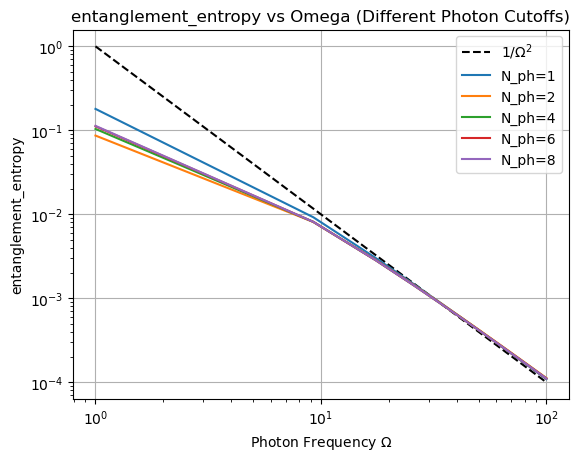

In [23]:
curves = [
    (results[0], results[1], f"N_ph={N_ph}")
    for N_ph, results in results_all_photon_cutoffs.items()
]

loglog_plot_observable_vs_omega_multi(results_all_photon_cutoffs, observable=observable)

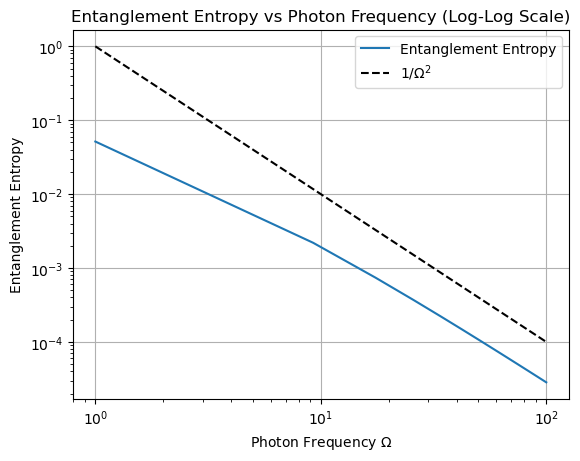

In [ ]:
plot_entanglement_entropy_vs_omega_log_log(results[0], results[1])